In [1]:
import plotly.express as px
import plotly.graph_objects as go

import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from fbprophet import Prophet

In [2]:
from sklearn.metrics import r2_score

def plot_y_pred(y_test, y_pred):
    plt.figure(figsize=(8, 5))
    plt.plot(y_test, c='r')
    plt.plot(y_pred, c='b')
    plt.show()
    print("R2=", r2_score(y_test, y_pred).round(3))
    error = abs(y_test - y_pred)
    print("MAE=", error.mean().round(3))
    print("rmse=", np.sqrt((error**2).mean()).round(3))
    print("max=", max(error).round(3))

def plot_y_pred2(xaxis, y_test, y_pred):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=xaxis, y=y_test, mode='lines', name='Test'))
    fig.add_trace(go.Scatter(x=xaxis, y=y_pred, mode='lines', name='Pred'))
    fig.show()

    y_test = y_test.to_numpy()

    print("R2=", r2_score(y_test, y_pred))
    error = abs(y_test - y_pred)
    print("MAE=", error.mean())
    print("rmse=", np.sqrt((error**2).mean()))
    print("max=", max(error))

def feature_importances_fig(features, importances):
    df = pd.DataFrame({'feature':features,'importance':importances})
    df = df.sort_values('importance', ascending=False)
    ypos = np.arange(len(df.feature))

    plt.figure(figsize=(6,4))
    plt.barh(df.feature, df.importance)
    plt.yticks(ypos, df.feature)
    plt.xlabel('Importance')
    plt.ylabel('Variable')
    plt.xlim(0, 1)
    plt.ylim(-1, len(df.feature))
    plt.show()

# Load Data & plot

In [3]:
df_org = pd.read_csv('https://raw.githubusercontent.com/DaniyolKim/dp2/main/result.csv')
df_org = pd.DataFrame({'time': pd.to_datetime(df_org['Unnamed: 0']), 'elec': df_org['elec']})

In [4]:
fig = px.line(df_org, x="time", y="elec")
fig.show()

In [5]:
fig = px.histogram(df_org, x="elec")
fig.show()

# Data time split
### 연, 월, 일, 시간, 휴무 column 추가

In [6]:
df_date_split = df_org.copy()
df_date_split['year'] = df_date_split['time'].dt.year
df_date_split['month'] = df_date_split['time'].dt.month
df_date_split['day'] = df_date_split['time'].dt.day
df_date_split['dayofweek'] = df_date_split['time'].dt.dayofweek
df_date_split['hour'] = df_date_split['time'].dt.hour
df_date_split

,time,elec,year,month,day,dayofweek,hour
0,2019-01-01 00:00:00,3330.816,2019,1,1,1,0
1,2019-01-01 01:00:00,3339.200,2019,1,1,1,1
2,2019-01-01 02:00:00,3287.616,2019,1,1,1,2
3,2019-01-01 03:00:00,3287.040,2019,1,1,1,3
4,2019-01-01 04:00:00,3372.672,2019,1,1,1,4
...,...,...,...,...,...,...,...
20419,2021-04-30 19:00:00,3604.800,2021,4,30,4,19
20420,2021-04-30 20:00:00,3458.944,2021,4,30,4,20
20421,2021-04-30 21:00:00,3335.808,2021,4,30,4,21
20422,2021-04-30 22:00:00,3230.528,2021,4,30,4,22


In [7]:
dayOffList = [datetime.datetime(2019,1,1),
                  datetime.datetime(2019,2,4),
                  datetime.datetime(2019,2,5),
                  datetime.datetime(2019,2,6),
                  datetime.datetime(2019,3,1),
                  datetime.datetime(2019,5,5),
                  datetime.datetime(2019,5,12),
                  datetime.datetime(2019,6,6),
                  datetime.datetime(2019,8,15),
                  datetime.datetime(2019,9,12),
                  datetime.datetime(2019,9,13),
                  datetime.datetime(2019,9,14),
                  datetime.datetime(2019,10,3),
                  datetime.datetime(2019,10,9),
                  datetime.datetime(2019,12,25),
                  
                  datetime.datetime(2020,1,1),
                  datetime.datetime(2020,1,24),
                  datetime.datetime(2020,1,25),
                  datetime.datetime(2020,1,26),
                  datetime.datetime(2020,3,1),
                  datetime.datetime(2020,4,30),
                  datetime.datetime(2020,5,5),
                  datetime.datetime(2020,6,6),
                  datetime.datetime(2020,8,15),
                  datetime.datetime(2020,8,17),
                  datetime.datetime(2020,9,30),
                  datetime.datetime(2020,10,1),
                  datetime.datetime(2020,10,2),
                  datetime.datetime(2020,10,3),
                  datetime.datetime(2020,10,9),
                  datetime.datetime(2020,12,25),

                  datetime.datetime(2021,1,1),
                  datetime.datetime(2021,2,11),
                  datetime.datetime(2021,2,12),
                  datetime.datetime(2021,2,13),
                  datetime.datetime(2021,3,1)
                  # datetime.datetime(2021,5,5),
                  # datetime.datetime(2021,5,19),
                  # datetime.datetime(2021,6,6),
                  # datetime.datetime(2021,8,15),
                  # datetime.datetime(2021,9,20),
                  # datetime.datetime(2021,9,21),
                  # datetime.datetime(2021,9,22),
                  # datetime.datetime(2021,10,3),
                  # datetime.datetime(2021,10,9),
                  # datetime.datetime(2021,12,25),
                  ]

def IsDayOff(d):
  for dayOff in dayOffList:
    if (d.dayofweek > 4): # 토,일요일 휴무 설정
      return 1
    elif (d.year == dayOff.year and d.month == dayOff.month and d.day == dayOff.day): #공휴일 설정
      return 1
  return 0

In [8]:
df_date_split['dayOff'] = df_date_split['time'].apply(IsDayOff)

In [9]:
df = df_date_split.copy()

# 학습 data와 테스트 data 구별


## 학습(df_train) : 2019.1.1 ~ 2020.12.31

In [10]:
df_train = df[df['time'] < datetime.datetime(2021,1,1)]

## 테스트(df_2021) : 2021.1.1 ~ 2021.4.30

In [11]:
df_2021 = df[df['time'] >= datetime.datetime(2021,1,1)]

In [12]:
fig = px.scatter(df_train, x="time", y="elec", color='dayOff')
fig.show()
# blue line이 day off임에도 튀는 구간이 있음을 알 수 있다.
# day off임에도 전력이 높다는 것은 해당 시점에 전력을 사용할 만한 이벤트(청소 등)가 있었다고 추측할 수 있음

In [13]:
fig = px.scatter(df_2021, x="time", y="elec", color='dayOff')
fig.show()

# Random forest

In [14]:
# 학습
features = ['year','month', 'day', 'hour', 'dayofweek', 'dayOff']

X = df_train[features].values
y = df_train['elec'].values
X_train, X_test, y_train, y_test = train_test_split(X, y)

model = RandomForestRegressor(n_estimators= 100)
model.fit(X_train, y_train)
model.score(X_test, y_test) # R2

0.9734125047665079

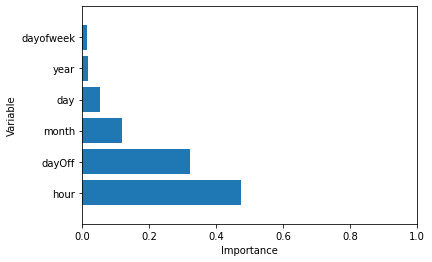

In [15]:
feature_importances_fig(features, model.feature_importances_)

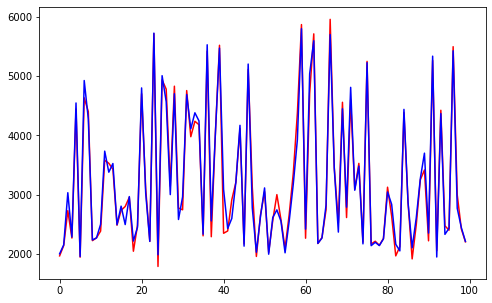

R2= 0.98
MAE= 111.201
rmse= 159.478
max= 737.911


In [16]:
y_pred = model.predict(X_test)
plot_y_pred(y_test[:100], y_pred[:100])

## (elec, time only)검증

In [17]:
# 2021년 data 예측
# 1~3월 구간에는 오차가 커보이며, 4월부터 안정화 되는 것으로 보인다.
features = ['year','month', 'day', 'hour', 'dayofweek', 'dayOff']
X_test_2021 = df_2021[features].values
y_pred_2021 = model.predict(X_test_2021)

plot_y_pred2(df_2021['time'], df_2021['elec'], y_pred_2021)

R2= 0.6875138727589222
MAE= 385.77057755353
rmse= 523.4034007511486
max= 1931.0804799999978


In [18]:
# 2021년 4월 data 예측
df_2021_04 = df_2021[df_2021['time'] >= datetime.datetime(2021,4,1)]
features = ['year','month', 'day', 'hour', 'dayofweek', 'dayOff']
X_test_2021_04 = df_2021_04[features].values
y_pred_2021_04 = model.predict(X_test_2021_04)

plot_y_pred2(df_2021_04['time'], df_2021_04['elec'], y_pred_2021_04)

R2= 0.8173097460964298
MAE= 254.41790460069453
rmse= 402.5988220148735
max= 1931.0804799999978


# Prophet

In [19]:
df_prophet = pd.DataFrame({'ds': df_train['time'], 'y': df_train['elec'].values})
# prophet 참고 : https://hyperconnect.github.io/2020/03/09/prophet-package.html
model = Prophet(changepoint_prior_scale=0.10, weekly_seasonality=30)
model.add_country_holidays(country_name='KR')
model.fit(df_prophet)
future = model.make_future_dataframe(periods=20424, freq='H')
forecast = model.predict(future)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


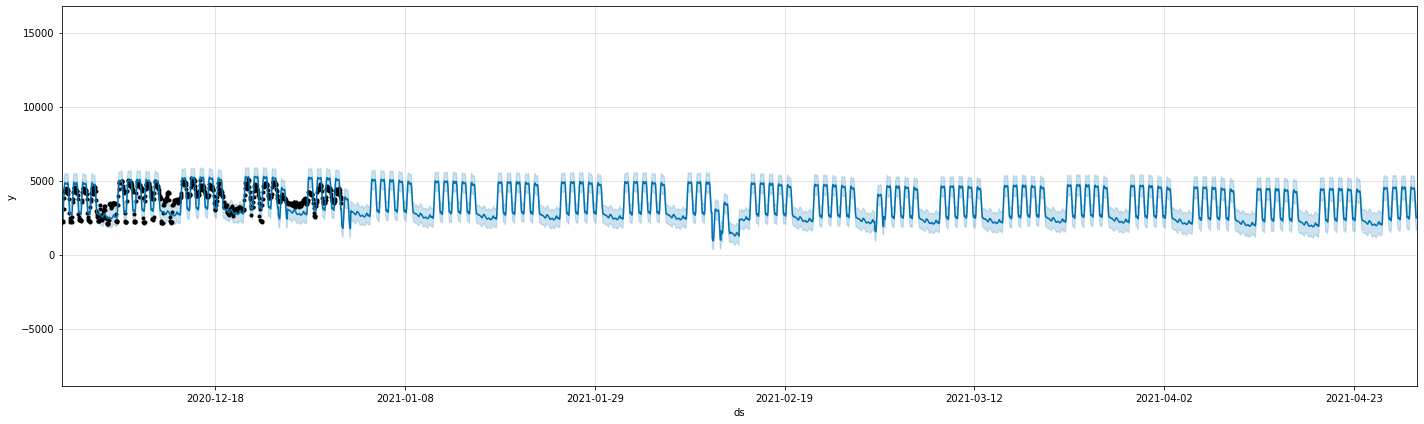

In [20]:
model.plot(forecast, figsize=(20, 6))
plt.xlim([datetime.datetime(2020, 12, 1), datetime.datetime(2021, 4, 30)])
plt.show()

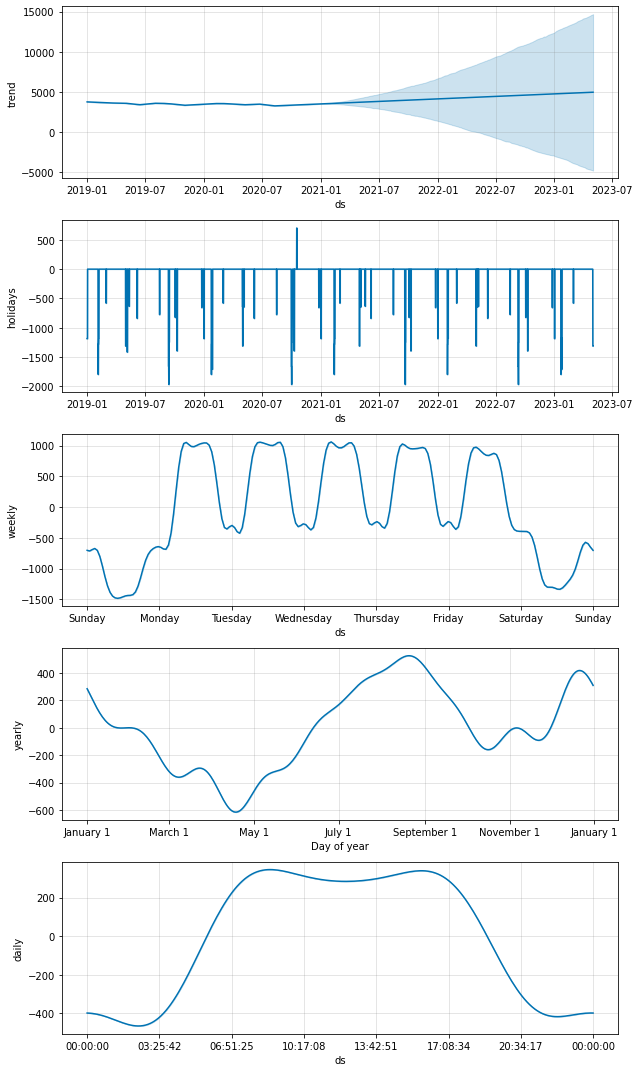

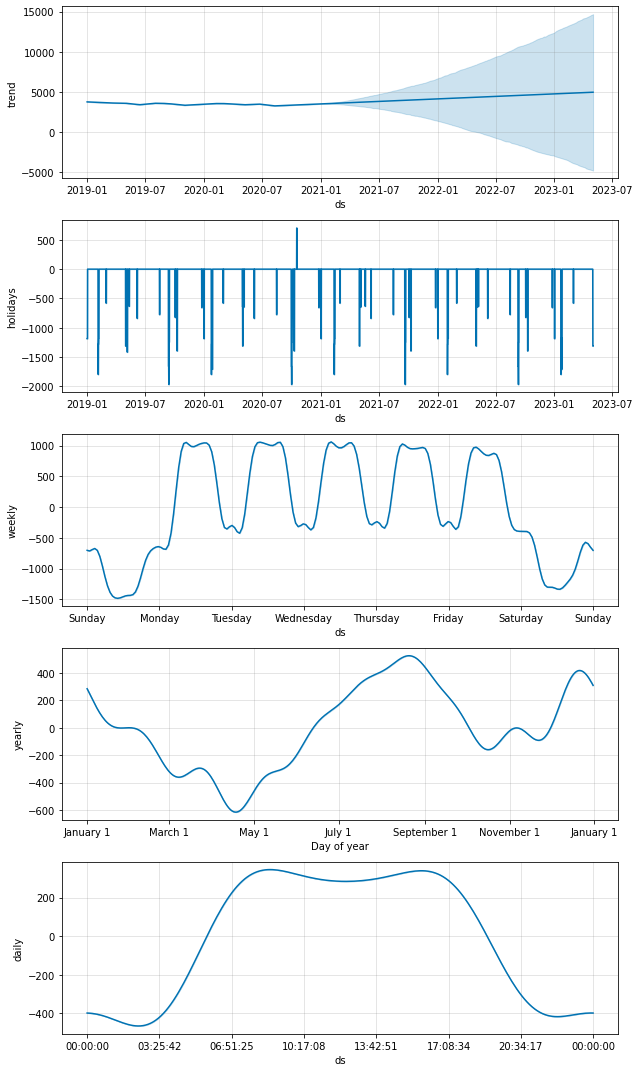

In [21]:
model.plot_components(forecast)

## (elec, time only)검증

In [22]:
# 2021년 data 예측
y_test_2021 = df_2021['elec']
y_pred_2021 = forecast[(forecast['ds'] >= datetime.datetime(2021,1,1)) & (forecast['ds'] < datetime.datetime(2021,5,1))]

plot_y_pred2(df_2021['time'], y_test_2021, y_pred_2021['yhat'])

R2= 0.6742006203358267
MAE= 429.8171510891646
rmse= 534.436727184747
max= 2550.9101976088677


In [23]:
# 2021년 4월 data 예측
y_test_2021_04 = df_2021[df_2021['time'] >= datetime.datetime(2021,4,1)]
y_pred_2021_04 = forecast[(forecast['ds'] >= datetime.datetime(2021,4,1)) & (forecast['ds'] < datetime.datetime(2021,5,1))]

plot_y_pred2(y_test_2021_04['time'], y_test_2021_04['elec'], y_pred_2021_04['yhat'])

R2= 0.7159841510893645
MAE= 373.7616042262008
rmse= 501.97963442508234
max= 2550.9101976088677


# **결과 분석**
## Randomforest vs Prophet
#### 2021년 예측 결과 비교
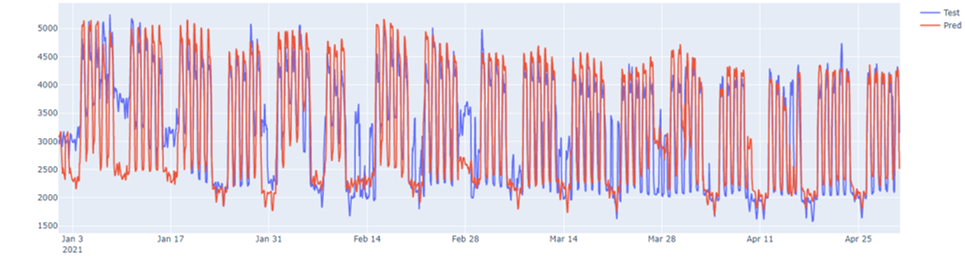
-Randomforest
*   R2= 0.697799626173595
*   MAE= 379.9614631588541
*   rmse= 514.7171843622101
*   max= 1973.7998399999988
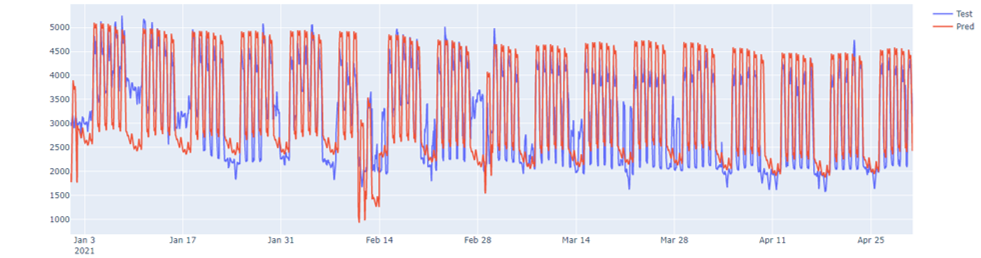
-Prophet
*   R2= 0.6742006203358267
*   MAE= 429.8171510891646
*   rmse= 534.436727184747 
*   max= 2550.9101976088677



## 참고사항
### 21년 4월 예측 비교
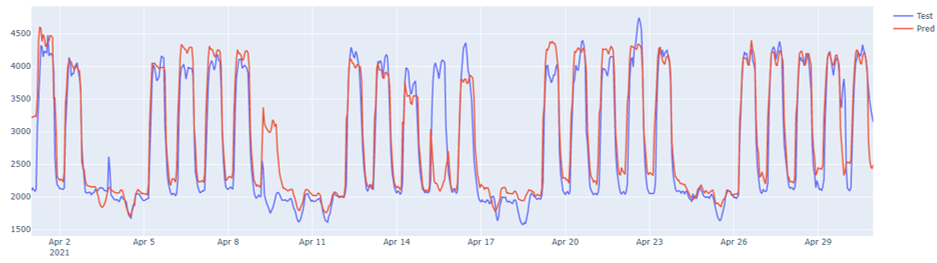
-Randomforest
*   R2= 0.8173097460964298
*   MAE= 254.41790460069453
*   rmse= 402.5988220148735
*   max= 1931.0804799999978

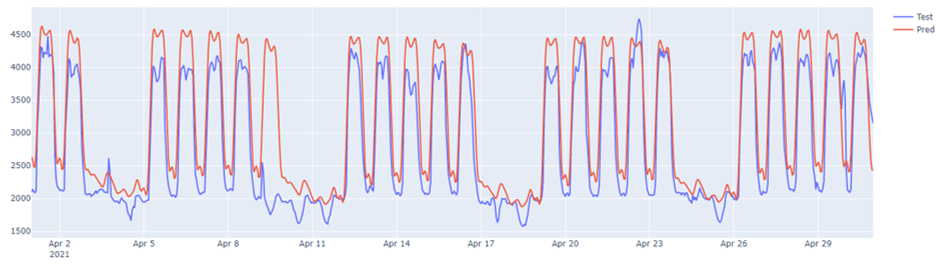

Prophet
*   R2= 0.7159841510893645
*   MAE= 373.7616042262008
*   rmse= 501.97963442508234
*   max= 2550.9101976088677

### 매해 4월 둘째주 금요일에 전력량이 적음
 - 해당 시점에 조기 퇴근등의 전력 사용량이 줄어드는 이벤트가 있을 것으로 추측
 - random forest에서는 해당 event에 대해서 자동 감지를 함
 - prophet에서는 자동 감지 못함

### 4월 15일 예측 차이 발생
 - 20년 4월 15일에 전력 사용 적은 case 발생
 - random forest에서는 해당 event에 대해서 감지함
 - prophet에서는 감지 못함